# Jupyter Notebook for the Data Analysis of Alkyne Semihydrogenation

This notebook is inspired/based on work and analyses done in:

* S. K. Kariofillis, A. G. Doyle *et al.*, *J. Am. Chem. Soc.* **2022**, *144*, 1045-1055. (https://pubs.acs.org/doi/10.1021/jacs.1c12203)
* https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html (last accessed 10.08.22)
* talktorial from the Volkamer lab: https://projects.volkamerlab.org/teachopencadd/talktorials/T006_compound_maximum_common_substructures.html (last accessed 10.08.22)
* S. H. Newman-Stonebraker, A. G. Doyle *et al.*, *Science* **2021**, *374*, 301-308. Jupyter notebook available under: https://github.com/SigmanGroup/Threshold  
* J. Dotson, M. Sigman *et al.*, *J. Am. Chem. Soc.* **2023**, *145, 1*, 110-121. Jupyter notebook available under: https://github.com/SigmanGroup/Multiobjective_Optimization

The clustering (Parts A-E) and threshold analysis (Part F) + regression analysis (Part G-H) can be run independently.

In [1]:
#Import libraries

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

#working with arrays
import numpy as np
from numpy import percentile

#working with dataframes
import os,sys,shutil,glob,pickle
import pandas as pd
import xlrd

#working with molecules
from rdkit import Chem

#Matplotlib, seaborn and associated plotting modules
import matplotlib
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import seaborn as sns


## A. Load Data and Delete NaN

In [2]:
#********************************************************************
#Workbook Sheet containing DFT calculated descriptors
#********************************************************************
df1 = pd.read_excel("DataSet_InternalAlkynes.xlsx",sheet_name="DataSheet")
df1.drop(0,axis=0, inplace=True)
df1.dropna(inplace=True)
df1.set_index("Alkyne Number", inplace=True)

df2 = pd.read_excel("DataSet_TerminalAlkynes.xlsx",sheet_name="DataSheet")
df2.drop(0,axis=0, inplace=True)
df2.drop(684,axis=0,inplace=True) #borane weird valence structure
df2.dropna(inplace=True)
df2["Alkyne Number"] = df2["Alkyne Number"].astype(int) + len(df1)
df2.set_index("Alkyne Number", inplace=True)

df = df1.append(df2)
df.drop(["NImag"],axis=1, inplace=True)


#drop different columns - SMILES and not averaged descriptors
Smiles = pd.DataFrame(df["SMILES"])
df.drop(["SMILES"],axis=1, inplace=True)
df.drop(columns=["x26","x27"], inplace = True)
df.drop(columns=["x30","x31"], inplace = True)
df.drop(columns=["x34","x35","x36","x37","x38","x39"], inplace = True)
df.drop(columns=["x46","x47","x48","x49","x50","x51"], inplace = True)
df.drop(columns=["x61","x62","x63","x64","x65","x66","x67","x68","x69","x70","x71","x72","x73","x74","x75","x76","x77","x78","x79","x80","x81"], inplace = True)

#to be checked for search for tested candidates
inchi = Smiles["SMILES"].map(Chem.MolFromSmiles).map(Chem.MolToInchi)
Smiles = Smiles[~inchi.duplicated()]#.set_index('SMILES')

#********************************************************************
#Workbook Sheet containing SMILES of tested substrates
#********************************************************************
subs = pd.read_excel("DataSet_Substrates.xlsx",sheet_name="DataSheet")
subs.drop(["Substrate"],axis=1, inplace=True)
subs.dropna(inplace=True)
subs["SMILES"] = subs["SMILES"].map(Chem.MolFromSmiles).map(Chem.MolToInchi)
inchi_subs = subs

#********************************************************************
#Find candidates that were used as substrates
#********************************************************************
Candidates=inchi.where(inchi.isin(inchi_subs["SMILES"])==True).dropna()
condition=inchi_subs.index[inchi_subs["SMILES"].isin(inchi)==True].tolist()
condition2=inchi_subs.where(inchi.isin(inchi_subs["SMILES"])==True).dropna()
Candidates=pd.DataFrame(Candidates)
Candidates["copy_index"] = Candidates.index
Candidates = pd.merge(Candidates, inchi_subs, on=['SMILES'], how='inner')
Candidates.set_index("copy_index",inplace=True)

#********************************************************************
#Workbook Sheet containing SMILES of literature substrates
#********************************************************************
lit_subs = pd.read_excel("DataSet_LiteratureSubstrates.xlsx",sheet_name="DataSheet")
lit_subs.rename(columns=lit_subs.iloc[0], inplace=True)
lit_subs.drop(0,axis=0, inplace=True)
lit_subs.drop(lit_subs.iloc[:,7:],axis=1, inplace=True)
lit_subs.drop(["Substrate"],axis=1, inplace=True)
lit_subs.dropna(inplace=True)
lit_subs["SMILES"] = lit_subs["SMILES"].map(Chem.MolFromSmiles).map(Chem.MolToInchi)
lit_inchi_subs = lit_subs

#********************************************************************
#Find candidates that were used in literature
#********************************************************************
lit_Candidates=inchi.where(inchi.isin(lit_inchi_subs["SMILES"])==True).dropna()
lit_condition=lit_inchi_subs.index[lit_inchi_subs["SMILES"].isin(inchi)==True].tolist()
lit_condition2=lit_inchi_subs.where(inchi.isin(lit_inchi_subs["SMILES"])==True).dropna()
lit_Candidates=pd.DataFrame(lit_Candidates)
lit_Candidates["copy_index"] = lit_Candidates.index
lit_Candidates = pd.merge(lit_Candidates, lit_inchi_subs, on=['SMILES'], how='inner')
lit_Candidates.set_index("copy_index",inplace=True)
lit_Candidates["Number of Occurences"]=lit_Candidates["Number of Occurences"].astype(float)
lit_Candidates["Average Yield"]=lit_Candidates["Average Yield"].astype(float)

#Only Candidates that occured three times or more
lit_Candidates=lit_Candidates.where(lit_Candidates["Number of Occurences"]>2)

RDKit WARNING: [11:54:06] WARNING: Omitted undefined stereo
[11:54:06] WARNING: Omitted undefined stereo
[11:54:06] WARNING: Metal was disconnected
[11:54:06] WARNING: Metal was disconnected
[11:54:06] WARNING: Omitted undefined stereo
[11:54:06] WARNING: Metal was disconnected
[11:54:06] WARNING: Metal was disconnected
[11:54:06] WARNING: Omitted undefined stereo
[11:54:06] WARNING: Omitted undefined stereo
[11:54:06] WARNING: Metal was disconnected
[11:54:06] WARNING: Metal was disconnected
[11:54:06] WARNING: Omitted undefined stereo
[11:54:06] WARNING: Omitted undefined stereo
[11:54:06] WARNING: Metal was disconnected
[11:54:06] WARNING: Omitted undefined stereo
[11:54:06] WARNING: Omitted undefined stereo
[11:54:06] WARNING: Omitted undefined stereo
[11:54:06] WARNING: Metal was disconnected
[11:54:06] WARNING: Omitted undefined stereo
[11:54:06] WARNING: Omitted undefined stereo
[11:54:06] WARNING: Omitted undefined stereo
[11:54:06] WARNING: Omitted undefined stereo
[11:54:06] 

# B. Preprocessing of DFT Data 

In [3]:
#********************************************************************
#Standardize and eliminate collinear features
#********************************************************************
from sklearn.preprocessing import scale

# standardize
df=pd.DataFrame(scale(df),index=df.index, columns=df.columns)

# drop zero-variance features
zero_std_cols = df.columns[df.std() == 0]
df=df[df.columns.difference(zero_std_cols)]

print (f"Dropping {len(zero_std_cols)} features {zero_std_cols}")

# drop highly correlated features
df_corr = df.corr().abs()
upper = df_corr.where(np.triu(np.ones(df_corr.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
df = df.drop(to_drop, axis=1)

print (f"Dropping {len(to_drop)} features {to_drop}")
print (f"Number of features left:  {len(df.columns)}")


Dropping 0 features Index([], dtype='object')
Dropping 4 features ['x7', 'x8', 'x22', 'x60']
Number of features left:  40


In [ ]:
#********************************************************************
#Pearson Correlation Matrix vor Visualization
#********************************************************************

# Generate a mask for the upper triangle
mask = np.zeros_like(df_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(20, 15))
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)
ax.tick_params(length=12,width=3)
ax.tick_params(which='minor', length=6, width=3)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True, sep=100)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(df_corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0, linewidths=.5)
cbar = ax.collections[0].colorbar
# here set the labelsize by 20
cbar.ax.tick_params(labelsize=15)

fig.suptitle('Correlation matrix of features', fontsize=25)


fig.tight_layout()
#fig.savefig('Correlation_Matrix.tiff',dpi=600, pad_inches = .1, bbox_inches = 'tight')

# C. Clustering with PCA & UMAP

In [ ]:
#********************************************************************
#Create PCA and UMAP embeddings from features
#********************************************************************

from sklearn.decomposition import PCA
from umap import UMAP

# define the dimensionalities of the reduced representation to study
dims = [len(df.columns), 30, 20, 10, 5, 2]

# dictionary to store data at different levels of dimensionality reduction
dfs={}

# UMAP section
n_neighbors = np.int(np.sqrt(df.shape[1]))
for dim in dims:
    key = f"umap{dim}"
    dfs[key] = pd.DataFrame(UMAP(n_components=dim, n_neighbors=n_neighbors, random_state=42).fit_transform(df),
                            index=df.index)
# PCA section
pc = pd.DataFrame(PCA(n_components=None).fit_transform(df), index=df.index)
for dim in dims:
    key = f"pc{dim}"
    dfs[key] = pc.iloc[:, :dim]

In [ ]:
#********************************************************************
#Visualization of the embeddings
#********************************************************************

fig, axs = plt.subplots(1, 2, figsize=(12, 6)) 
dfs['pc2'].columns = ['PC1', 'PC2']
dfs['umap2'].columns = ['UMAP1', 'UMAP2']

#-----------------------------------------------------------------------------------------------------#
axs[0].scatter(x='PC1', y='PC2', data=dfs['pc2'], s=20, alpha=0.7, linewidth=0.25,
                  edgecolor='face')
for axis in ['top','bottom','left','right']:
    axs[0].spines[axis].set_linewidth(3)
axs[0].tick_params(length=12,width=3)
axs[0].set_ylim([-12,12])
axs[0].set_xlim([-10,30])
axs[0].xaxis.set_minor_locator(plt.MaxNLocator(4))
axs[0].xaxis.set_major_locator(plt.MaxNLocator(4))
axs[0].yaxis.set_major_locator(plt.MaxNLocator(4))
axs[0].set_yticks([-9,-3,3,9], minor=True)
axs[0].set_xticks([-5,5,15,25], minor=True)
axs[0].tick_params(which='minor', length=6, width=3,labelsize = 15)
axs[0].set_title("PC Projection", fontsize=18)
axs[0].set_xlabel('PC1', fontsize = 15)
axs[0].set_ylabel('PC1', fontsize = 15)
#-----------------------------------------------------------------------------------------------------#
axs[1].scatter(x='UMAP1', y='UMAP2', data=dfs['umap2'], s=20, alpha=0.7, linewidth=0.25,
                  edgecolor='face')
for axis in ['top','bottom','left','right']:
    axs[1].spines[axis].set_linewidth(3)
axs[1].tick_params(length=12,width=3)
axs[1].set_ylim([-12.5,22.5])
axs[1].set_xlim([-10,25])
axs[1].set_xticks([-10,-3,4,11,18,25], major=True)
axs[1].set_xticks([-6.5,0.5,7.5,14.5,21.5], minor=True)
axs[1].set_yticks([-12.5,-5.5,1.5,8.5,15.5,22.5],major=True)
axs[1].set_yticks([-9,-2,5,12,19], minor=True)
axs[1].tick_params(which='minor', length=6, width=3,labelsize = 15)
axs[1].set_title("UMAP Projection", fontsize=18)
axs[1].set_xlabel('UMAP1', fontsize = 15)
axs[1].set_ylabel('UMAP2', fontsize = 15)
#-----------------------------------------------------------------------------------------------------#

plt.tight_layout(h_pad=0.5, w_pad=5, pad=3)
#fig.savefig('PCAvsUMAP.tiff',dpi=600, pad_inches = .1, bbox_inches = 'tight')

## Rationalize number of optimal clusters and reduced representations

Initial silhouette scores for number of reduced representations. The silhouette score should be as high as possible, while little fluctuations in score with different reduced representations indicate the optimal number of UMAPs.

In [ ]:
#********************************************************************
#Silhouette Score Analysis for PCA and UMAP
#********************************************************************

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, fclusterdata
from sklearn.metrics import silhouette_score

#-----------------------------------------------------------------------------------------------------#
def silhouette_scores_hierarchical(data, n_cls_list):
    """helper function to compute a silhouette score for hierarchical clustering using Ward linkage"""
    z = linkage(data, method='ward')
    result = pd.Series(index=n_cls_list, dtype=float)
    for n_cls in n_cls_list:
        cls = fcluster(z, n_cls, criterion='maxclust')
        result.loc[n_cls] = silhouette_score(data, cls)
    return result
#-----------------------------------------------------------------------------------------------------#

# Define the numbeor of clusters to study
N_CLS_list = list(range(5, 21))

# populate silhouette scores for all number of clusters and all dimensionality reductions that are pre-calculated
silh_scores = pd.DataFrame(index=N_CLS_list)
for key, value in dfs.items():
    silh_scores[key] = silhouette_scores_hierarchical(value, N_CLS_list)

# plot the silhouette scores with visualized embeddings
grouped=silh_scores.groupby(silh_scores.columns.str.startswith('umap'), axis=1)

fig, axes = plt.subplots(1,2, figsize=(12,6))

for (key, ax) in zip(grouped.groups.keys(), axes.flatten()):
    grouped.get_group(key).plot(ax=ax)

    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(3)
    ax.tick_params(length=12,width=3,labelsize = 15)
    ax.set_xlabel('Number of Clusters', fontsize = 15)
    ax.set_ylabel('Average Silhouette Score', fontsize = 15)
    ax.legend(loc=1,fontsize=12)
    
plt.tight_layout(h_pad=0.5, w_pad=5, pad=3)
#fig.savefig('SilhouetteScore.tiff',dpi=600, pad_inches = .1, bbox_inches = 'tight')


Things to look for in the silhouette analysis:
    
    a) above average score for all clusters
    b) uniform silhouette thickness
    c) no wide fluctuations in size

This part is based on a scikit-learn Jupyter notebook (https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)

In [ ]:
#********************************************************************
#Silhouette Analysis for UMAP with 5 embeddings
#********************************************************************

from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import AgglomerativeClustering
import matplotlib.cm as cm

X=dfs["umap5"]
for n_clusters in range(5,20):
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
    
    #-----------------------------------------------------------------------------------------------------#
    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from [-1,1], we opt for [-0.1, 1] for depiction purposes
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters)*10 is demarcate silhouette plots of individual clusters.
    ax1.set_ylim([0, len(X) + (n_clusters) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility (as chosen in the scikit-learn example).
    
    clusterer = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward')
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.3 * size_cluster_i, str(i), fontsize=12)

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    for axis in ['top','bottom','left','right']:
        ax1.spines[axis].set_linewidth(3)
    ax1.tick_params(length=12,width=3, labelsize=15)
    #ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("Silhouette Coefficient Values", fontsize=15)
    ax1.set_ylabel("Cluster label", fontsize=15)

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
    #-----------------------------------------------------------------------------------------------------#
    
    #-----------------------------------------------------------------------------------------------------#
    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral((cluster_labels.astype(float)) / n_clusters)
    ax2.scatter(dfs['umap2']["UMAP1"], dfs['umap2']["UMAP2"], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    for axis in ['top','bottom','left','right']:
        ax2.spines[axis].set_linewidth(3)
    ax2.tick_params(length=12,width=3, labelsize=15)

    ax2.set_xlabel("UMAP1", fontsize=15)
    ax2.set_ylabel("UMAP2", fontsize=15)
    ax2.set_xticks([-10,-3,4,11,18,25], major=True)
    ax2.set_xticks([-6.5,0.5,7.5,14.5,21.5], minor=True)
    ax2.set_yticks([-12.5,-5.5,1.5,8.5,15.5,22.5],major=True)
    ax2.set_yticks([-9,-2,5,12,19], minor=True)
    ax2.tick_params(which='minor', length=6, width=3)
    #-----------------------------------------------------------------------------------------------------#
    
    plt.tight_layout(h_pad=0.5, w_pad=5, pad=3)
    plt.show()
    
    #save the plot with optimal number of clusters after checking
    #if i==5: #number to be changed here => (number of clusters - 1)
    #    fig.savefig('SilhouetteAnalysis_6clusters.tiff',dpi=600, pad_inches = .1, bbox_inches = 'tight')

In [ ]:
#********************************************************************
#Generation of Dendrogram with Optimal Hyperparameters
#********************************************************************

# final number of clusters to produce
NCLS = 6

# linkage and clustering for selected featurization
z = linkage(dfs['umap5'], method="ward")
cls = fcluster(z, NCLS, criterion='maxclust')

# plot the dendrogram
fig,ax=plt.subplots(figsize=(6, 6))
_=dendrogram(z, truncate_mode='lastp', p=NCLS, show_contracted=True,
             leaf_rotation=90, color_threshold=0)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)
ax.tick_params(length=12,width=3,labelsize=15)
ax.tick_params(which='minor', length=6, width=3)
plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=3)

#fig.savefig('Dendrogram.tiff',dpi=600, pad_inches = .1, bbox_inches = 'tight')

In [ ]:
#********************************************************************
#Plotting of Tested Substrates on Clustered Chemical Space Map
#********************************************************************

#Definition of color palette
color_palette = ["#E69F00", "#56B4E9", "#009E73", "#0072B2", "#D55E00", "#CC79A7", "#F0E442"]
color_palette_rgb = [matplotlib.colors.to_rgb(i) for i in color_palette]

#Plotting of clustered chemical space (p1) with star-shaped tested entries (p2), surrounded by circles (p3)
fig, ax = plt.subplots(figsize=(6, 6))
p1 = plt.scatter(x="UMAP1", y="UMAP2", data=dfs['umap2'], s=20, alpha=0.7, linewidth=0.25, edgecolor='face',
                cmap=matplotlib.colors.LinearSegmentedColormap.from_list("bla",color_palette_rgb), c=cls)
p2 = plt.scatter(x="UMAP1", y="UMAP2", data=dfs['umap2'].loc[Candidates.index],  s=70, alpha=0.7, linewidth=0.25, edgecolor='black', c="black", marker="*")
p3 = plt.scatter(x="UMAP1", y="UMAP2", data=dfs['umap2'].loc[Candidates.index],  s=80, alpha=0.7, linewidth=1, edgecolor='black', facecolor="none")


for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)
ax.tick_params(length=12,width=3, labelsize=15)

ax.set_xlabel("UMAP1", fontsize=15)
ax.set_ylabel("UMAP2", fontsize=15)
ax.set_xticks([-10,-3,4,11,18,25], major=True)
ax.set_xticks([-6.5,0.5,7.5,14.5,21.5], minor=True)
ax.set_yticks([-12.5,-5.5,1.5,8.5,15.5,22.5],major=True)
ax.set_yticks([-9,-2,5,12,19], minor=True)
ax.tick_params(which='minor', length=6, width=3)

plt.tight_layout(h_pad=0.5, w_pad=5, pad=3)
plt.show()

#fig.savefig('Substrates_on_clusters.tiff',dpi=600, pad_inches = .1, bbox_inches = 'tight')





In [ ]:
#********************************************************************
#Plotting of Semihydrogenation Rates on Alkyne Chemical Space Map
#********************************************************************

#Plotting of clustered chemical space (p1) with harsher hydrogenation candidates (5 bar, 80 °C, 16 h) (p2)
# and mild hydrogenation candidates (1 bar, 80 °C, 10 h) (p3)
fig, ax = plt.subplots(figsize=(6, 6))
p1 = plt.scatter(x="UMAP1", y="UMAP2", data=dfs['umap2'], s=20, alpha=0.7, linewidth=0.25, edgecolor='face',
                 c="lightgrey")
p2 = plt.scatter(x="UMAP1", y="UMAP2", data=dfs['umap2'].loc[Candidates.index.where(Candidates["Condition"]=="B").dropna().astype(int)], s=Candidates["Rates"].where(Candidates["Condition"]=="B").dropna()/Candidates["Rates"].max()*100+25, alpha=.7, linewidth=0.25, edgecolor='face', color="darkred")
p3 = plt.scatter(x="UMAP1", y="UMAP2", data=dfs['umap2'].loc[Candidates.index.where(Candidates["Condition"]=="A").dropna().astype(int)], s=Candidates["Rates"].where(Candidates["Condition"]=="A").dropna()/Candidates["Rates"].max()*100+25, alpha=.7, linewidth=0.25, edgecolor='face', color="#69d")


for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)
ax.tick_params(length=12,width=3, labelsize=15)

ax.set_xlabel("UMAP1", fontsize=15)
ax.set_ylabel("UMAP2", fontsize=15)
ax.set_xticks([-10,-3,4,11,18,25], major=True)
ax.set_xticks([-6.5,0.5,7.5,14.5,21.5], minor=True)
ax.set_yticks([-12.5,-5.5,1.5,8.5,15.5,22.5],major=True)
ax.set_yticks([-9,-2,5,12,19], minor=True)
ax.tick_params(which='minor', length=6, width=3)

plt.tight_layout(h_pad=0.5, w_pad=5, pad=3)
plt.show()

#fig.savefig('Susbstrate_Rates_on_Space.tiff',dpi=600, pad_inches = .1, bbox_inches = 'tight')


In [ ]:
#********************************************************************
#Plotting of Literature Reported Semihydrogenation Yields 
#of Substrates Occurring more than 2 times
#********************************************************************
fig, ax = plt.subplots(figsize=(7, 6))
p1 = plt.scatter(x="UMAP1", y="UMAP2", data=dfs['umap2'], s=20, alpha=0.7, linewidth=0.25, edgecolor='face',
                 c="lightgrey")

p2 = plt.scatter(x="UMAP1", y="UMAP2", data=dfs['umap2'].loc[lit_Candidates.index], s=lit_Candidates["Number of Occurences"]/lit_Candidates["Number of Occurences"].max()*200, alpha=.7, linewidth=0.25, edgecolor='face', c=lit_Candidates["Average Yield"], cmap=sns.dark_palette("#69d", reverse=True, as_cmap=True))

cbar = plt.colorbar(p2)
plt.clim(0,100)
cbar.ax.tick_params(labelsize=12) 


for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)
ax.tick_params(length=12,width=3, labelsize=15)

ax.set_xlabel("UMAP1", fontsize=15)
ax.set_ylabel("UMAP2", fontsize=15)
ax.set_xticks([-10,-3,4,11,18,25], major=True)
ax.set_xticks([-6.5,0.5,7.5,14.5,21.5], minor=True)
ax.set_yticks([-12.5,-5.5,1.5,8.5,15.5,22.5],major=True)
ax.set_yticks([-9,-2,5,12,19], minor=True)
ax.tick_params(which='minor', length=6, width=3)

plt.tight_layout(h_pad=0.5, w_pad=5, pad=3)
plt.show()

#fig.savefig('Literature_on_clusters.tiff',dpi=600, pad_inches = .1, bbox_inches = 'tight')

# D. Selection of Molecules from Clusters

#### Central Molecule of Each Cluster

In [ ]:
#********************************************************************
#Selection of Central Molecules in Each Cluster
#********************************************************************
from scipy.spatial.distance import cdist
from rdkit.Chem import Draw

# build rdkit molecules for all candidates
mols = pd.Series(Smiles["SMILES"].map(Chem.MolFromSmiles), index=df.index).to_frame('mol')
features='umap5'

# How many central molecules to display?
n_per_cluster = 5
                                                                            
# store central candidates for
cands=[]

for group, data in mols.groupby(cls):
    # get descriptor data for this cluster
    desc_data=dfs[features].loc[data.index]
    
    # compute distances of these molecules to their center
    dists=pd.Series(cdist([desc_data.mean()], desc_data)[0],
                    index=desc_data.index)
    
    # select top n central molecules
    selected=dists.sort_values().head(n_per_cluster).index
    
    smi=mols.loc[selected]['mol'].map(Chem.MolToSmiles)
    smi=smi.reset_index(drop=True).to_frame(f"Cluster{group}")
    cands.append(smi)
    
    print (f"Cluster {group}, n molecules: {len(data)}")
    ms = data['mol'].loc[selected]
    display(Draw.MolsToGridImage(ms, molsPerRow=n_per_cluster))
    img=Draw.MolsToGridImage(ms,molsPerRow=n_per_cluster,subImgSize=(200,200),returnPNG=False)
    
    #Saving of every single molecule selection for cluster
    #img.save("Cluster_"+str(group)+'.tiff')   

cands = pd.concat(cands, axis=1)



#### Maximum Common Substructure (MCS)

Further information about the applied algorithm can be found here: http://www.rdkit.org/docs/Cookbook.html#using-custom-mcs-atom-types

In [ ]:
from collections import defaultdict
from pathlib import Path
from copy import deepcopy
import random

from ipywidgets import interact, fixed, widgets

from rdkit import Chem, Geometry
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import rdFMCS
from rdkit.Chem import PandasTools



In [ ]:
#********************************************************************
#Generate Dataframe Containing SMILES 
#********************************************************************
compound_df = df1.append(df2)
compound_df.drop(["NImag"],axis=1, inplace=True)
compound_df.drop(compound_df.columns[1:],axis=1,inplace=True)
compound_df["ID"]=compound_df.index
print("Dataframe shape:", compound_df.shape)
compound_df.head()

In [ ]:
#********************************************************************
#Create SDF file with all molecules and IDs
#********************************************************************

PandasTools.AddMoleculeColumnToFrame(compound_df,'SMILES','ID') # pp = doesn't work for me
PandasTools.WriteSDF(compound_df, 'SDF.sdf', molColName='ID', properties=list(compound_df.columns))
sdf='SDF.sdf'
supplier = Chem.ForwardSDMolSupplier(sdf)
mols1 = list(supplier)

print(f"Set with {len(mols1)} molecules loaded.")


In [ ]:
#********************************************************************
#Apply FMCS algorithm and attribute MCS to every cluster
#********************************************************************

mols_df=pd.DataFrame(mols1)

mols_df=mols_df.groupby(cls)
for group, data in mols_df:
    mols=data.iloc[:,0].values.tolist()
    print(f"Set with {len(mols)} molecules loaded.")
    mcs1 = rdFMCS.FindMCS(mols,threshold=0.50) #this value can be changed to assess for percentage of all molecules
    print(f"MCS1 contains {mcs1.numAtoms} atoms and {mcs1.numBonds} bonds.")
    print("MCS SMARTS string:", mcs1.smartsString)
    
    # Draw substructure from Smarts
    m1 = Chem.MolFromSmarts(mcs1.smartsString)
    display(Draw.MolToImage(m1, legend="Cluster "+str(group)))

In [ ]:
#********************************************************************
#Function to highlight substructure in selected molecules
#********************************************************************

def highlight_molecules(molecules, mcs, number, label=True, same_orientation=True, **kwargs):
    """Highlight the MCS in our query molecules"""
    molecules = deepcopy(molecules)
    # convert MCS to molecule
    pattern = Chem.MolFromSmarts(mcs.smartsString)
    # find the matching atoms in each molecule
    matching = [molecule.GetSubstructMatch(pattern) for molecule in molecules[:number]]

    legends = None
    if label is True:
        legends = [x.GetProp("_Name") for x in molecules]

    # Align by matched substructure so they are depicted in the same orientation
    # Adapted from: https://gist.github.com/greglandrum/82d9a86acb3b00d3bb1df502779a5810
    if same_orientation:
        mol, match = molecules[0], matching[0]
        AllChem.Compute2DCoords(mol)
        coords = [mol.GetConformer().GetAtomPosition(x) for x in match]
        coords2D = [Geometry.Point2D(pt.x, pt.y) for pt in coords]
        for mol, match in zip(molecules[1:number], matching[1:number]):
            if not match:
                continue
            coord_dict = {match[i]: coord for i, coord in enumerate(coords2D)}
            AllChem.Compute2DCoords(mol, coordMap=coord_dict)

    return Draw.MolsToGridImage(
        molecules[:number],
        legends=legends,
        molsPerRow=5,
        highlightAtomLists=matching[:number],
        subImgSize=(200, 200),
        **kwargs,
    )

In [ ]:
highlight_molecules(mols, mcs1, 20)

# E. Diversity of the Clustering Workflow

In [ ]:
#********************************************************************
#Helper Functions for Sampling
#********************************************************************

from scipy.spatial.distance import pdist, squareform
def sample_dist(data):
    dists = pdist(data)
    return [ min(dists), np.mean(dists), max(dists)]

def kenStone(X, k, metric='euclidean'):
    # safety checks
    assert isinstance(k, int)
    assert k >= 2
    assert k <= X.shape[0]
    # distance matrix
    d = squareform(pdist(X, metric))
    # seed pick the pair that's furthest apart
    selected = list(np.unravel_index(np.argmax(d), d.shape))
    while len(selected) < k:
   
        #add sample whose minimum distance to the selected samples is largest
        selected.append(np.argmax(d[selected,].min(axis=0)))
    return selected


In [ ]:
# make a handful of umaps with various random seeds
umaps = []
for i in range(50):
    umaps.append(pd.DataFrame(UMAP(n_components=5, n_neighbors=n_neighbors).fit_transform(df),
                          index=df.index))
    
# add the original umap that was used for clustering
umaps = [dfs['umap5']] + umaps

# selection of dataset to use
dat = umaps[27]
NCLS=6

In [ ]:
#********************************************************************
#Clustering
#********************************************************************

ret_cls = []
for dat in umaps:
    # clustering
    z = linkage(dat, method="ward")
    cls = fcluster(z, NCLS, criterion='maxclust')
    
    selected = []
    for group, d in dat.groupby(cls):
        
        # compute distances of these molecules to their center
        dists=pd.Series(cdist([d.mean()], d)[0],
                        index=d.index)
        
        # select top n central molecules
        selected.append(dists.sort_values().index[0])
        
    dcls = sample_dist(dat.loc[selected])
    ret_cls.append(dcls)
    
ret_cls = pd.DataFrame(ret_cls, columns=[ 'clustering min. dist', 'clustering avg. dist', 'clustering max. dist'])

In [ ]:
#********************************************************************
#Kennard-Stone algorithm
#********************************************************************

ret_ks = []
for dat in umaps:
    ks = kenStone(dat, NCLS)
    dks = sample_dist(dat.iloc[ks])
    ret_ks.append(dks)

ret_ks = pd.DataFrame(ret_ks, columns=[ 'ks min dist', 'ks avg dist', 'ks max dist'])

In [ ]:
#********************************************************************
#Random Sampling
#********************************************************************

ret_rnd = []
for dat in umaps:
    for i in range(100):
        ret_rnd.append(sample_dist(dat.sample(NCLS)))
ret_rnd = pd.DataFrame(ret_rnd, columns=[ 'random min. dist', 'random avg. dist', 'random max. dist'])


In [ ]:
#********************************************************************
#Plots
#********************************************************************

fig, ax = plt.subplots(1,3, figsize=(18, 6))
ret_cls.plot(kind='hist', histtype='step', facecolor='#008000', edgecolor='k', 
             fill=True,
             subplots=True, ax=ax, color='black', bins=25, xlim=(-1, 20), density=True)

ret_rnd.plot(kind='hist', histtype='step', color='#0000C0', linewidth=2, linestyle='--',
             subplots=True, ax=ax, bins=25, xlim=(-1, 20), density=True)

for axis in ['top','bottom','left','right']:
    ax[0].spines[axis].set_linewidth(3)
    ax[1].spines[axis].set_linewidth(3)
    ax[2].spines[axis].set_linewidth(3)
ax[0].tick_params(length=12,width=3,labelsize=15)
ax[1].tick_params(length=12,width=3,labelsize=15)
ax[2].tick_params(length=12,width=3,labelsize=15)
ax[0].tick_params(which='minor', length=6, width=3,labelsize=15)
ax[1].tick_params(which='minor', length=6, width=3,labelsize=15)
ax[2].tick_params(which='minor', length=6, width=3,labelsize=15)

plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=3)
ax[0].set_ylabel('Density',fontsize=15)
ax[1].set_ylabel('Density',fontsize=15)
ax[2].set_ylabel('Density',fontsize=15)

ax[1].legend(loc="upper left")
ax[2].legend(loc="upper left")

plt.show()
#fig.savefig('RandomvsClusteringSelection.tiff',dpi=600, pad_inches = .1, bbox_inches = 'tight')




# F. Single-Node Decision Tree (Threshold Analysis)

## Reading data
### Choosing input files

- Sets up script to import data and parameters from excel
- populate this cell based on the excel spreadsheet that you want to be read
- populate y_cut with threshold value

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn import metrics
from matplotlib.colors import ListedColormap

In [5]:
comp_file = 'DataSet_AllAlkynes_TMS' # parameter excel file name 
comp_sheet = "DataSheet" # parameter excel sheet name
num_par = 44 # number of parameters
par_start_col = 3  # 0-indexed, first column number with descriptor values
comp_num_samples = 2716 # Number of substrates in sheet
y_label_col_comp = 0 # 0-indexed, the number of the column with the substrate ids

exp_file = 'DataSet_Tested' # data excel file name
exp_sheet = 'DataSheet' # data excel sheet name
exp_num_samples = 31 # include all the ligands, the empty rows will be removed later
response_col = 2 # 0-indexed, the column containing the experimental results
y_label_col_exp= 1 # 0-indexed, the number of the column with the substrate ids

y_cut = 0.033   # this sets the threshold value for 1/0 

### Sorting data

- Imports parameters and data and converts continuous data to binary data
- No user input required

In [6]:
#********************************************************************
#Creation of dataframe, extraction of descriptors and output variables
#********************************************************************

# make pd df for the descriptors
compinp = pd.read_excel(comp_file+".xlsx",comp_sheet,header=0,index_col=y_label_col_comp,nrows=comp_num_samples+1,usecols=list(range(0,(num_par+par_start_col))),engine='openpyxl')
compinp = compinp.drop(['SMILES'],axis=1)

compinp.dropna(inplace=True)
par_start_col = 1
compinp.index = compinp.index.map(str)

# make pd df for the experimental file
expinp = pd.read_excel(exp_file+".xlsx",exp_sheet,header=2,index_col=y_label_col_exp,nrows=exp_num_samples,usecols=list(range(0,response_col+1)),engine='openpyxl')

# names of the descriptors
X_names = list(compinp.iloc[0,par_start_col-1:num_par+par_start_col-1])

# labels for descriptors e.g. x1, x2, x3... make list then take only selection for descriptors
X_labels = list(compinp.columns)[par_start_col-1:num_par+par_start_col-1]

# removes names of the descriptors from compinp
compinp.drop(index=compinp.index[0],inplace=True)

# X_all = np array of descriptor values for all substrates
X_all = np.asarray(compinp[X_labels],dtype=np.float)

# np array of the alkyne ids from the descriptor file
y_labels_comp = np.asarray(list(compinp.index),dtype=str)

# compnan = array of True/False designating if a substrate has a missing descriptor value(s) or not
# nan = not a number. isnan returns True if Nan, in this case for any value in a row (axis of 1 = row).
compnan = np.isnan(X_all).any(axis=1)

# compares the arrays, and keeps the sample in y_labels_comp/X_all if the corresponding value in ~compnan = True.
# ~ means it inverts True and False in compnan. This is removing any substrate missing descriptors.
y_labels_comp,X_all = y_labels_comp[~compnan],X_all[~compnan]

# combines the labels and names of descriptors as a single value in a list e.g. "x1 E_HOMO" 
X_labelname = [" ".join(i) for i in zip(X_labels,X_names)]

# makes a dictionary with key of descriptor label, value of descriptor name
X_labelname_dict = dict(zip(X_labels,X_names))

# heading ('label') for the response column
resp_label = list(expinp.columns)[response_col-1]

# array of the experimental results
y = np.asarray(expinp.iloc[:,response_col-1],dtype=np.float)

# array of all the ligand ids in the experimental file (curated below to give ligands with results only)
y_labels_exp = np.asarray(list(expinp.index),dtype=str)

# array with True for experimental results present, False for none
mask_y = ~np.isnan(y)

# check if each value of y_labels_exp (ligand ids in exp file) is also in y_labels_comp (ligand ids in descriptor file),
# to give an array with True/False if a match is found (i.e. do we have the descriptors we need) 
mask_X = np.array([True if i in y_labels_comp else False for i in y_labels_exp])

# compares the two arrays, if same value is True in both then value = True in mask, otherwise = False.
# i.e. does the ligand have an experimental result and descriptors
mask = mask_y&mask_X

# ligands_removed is a list of ligands that had zero-values
count = 0
ligands_removed = []
for i in list(mask):
    if not i:
        ligands_removed.append(y_labels_exp[count])
    count += 1

print("Number of entries in experimental file before removing empty cells: {}".format(len(y)))
print("Removing {} entries with empty cells".format(len(y)-sum(mask)))
print('Entries removed: ', ligands_removed)

# remove all nan values from y, leaving experimental results
y = y[np.array(mask)]

# Convert reaction data to binary 1/0 based on y_cut
y_class = np.array([1 if result > y_cut else 0 for result in y])

# cut y_labels to only have ids for alkynes with results
y_labels = y_labels_exp[np.array(mask)]

# X = array of descriptor values for the alkynes with experimental results
X = np.asarray(compinp.loc[y_labels],dtype=np.float)



verbose = True
if verbose:
    print("Shape of descriptors file for all alkynes: {}".format(X_all.shape))
    print("Last three ids in the descriptor file: {}".format(y_labels_comp[-3:]))
    print("Shape of descriptors file for alkynes with experimental results: {}".format(X.shape))
    print("Shape of results file results (only alkynes with experimental results): {}".format(y.shape)) 
    print("Shape of results file labels (only alkynes with experimental results): {}".format(y_labels.shape))
    print("First descriptor cell (for alkynes with experimental results): {}".format(X[0,0]))
    print("Last descriptor cell (for alkynes with experimental results):  {}".format(X[-1,-1]))
    print('Alkynes with results:',y_labels)
    print(len(y),' Experimental results:', " : ", y)

Number of entries in experimental file before removing empty cells: 31
Removing 0 entries with empty cells
Entries removed:  []
Shape of descriptors file for all alkynes: (2713, 44)
Last three ids in the descriptor file: ['2714' '2715' '2716']
Shape of descriptors file for alkynes with experimental results: (31, 44)
Shape of results file results (only alkynes with experimental results): (31,)
Shape of results file labels (only alkynes with experimental results): (31,)
First descriptor cell (for alkynes with experimental results): 116.160149101698
Last descriptor cell (for alkynes with experimental results):  137.018901318926
Alkynes with results: ['2638' '1721' '1308' '928' '1439' '1151' '1588' '1382' '1167' '2492'
 '1267' '1805' '487' '1718' '2716' '1063' '2388' '2154' '2189' '2022'
 '1913' '1116' '2144' '2715' '1684' '2191' '2580' '2256' '2505' '1034'
 '1732']
31  Experimental results:  :  [0.039      0.0844338  0.087      0.054      0.023      0.128
 0.154      0.148      0.058     

N = 31
Feature: x17
Decision threshold = 0.96
Accuracy: 0.90
f1_score: 0.92
MCC: 0.80 
Recall: = 0.89
Classification Report: 
                 precision    recall  f1-score   support

0 ("negatives")       0.85      0.92      0.88        12
1 ("positives")       0.94      0.89      0.92        19

       accuracy                           0.90        31
      macro avg       0.90      0.91      0.90        31
   weighted avg       0.91      0.90      0.90        31



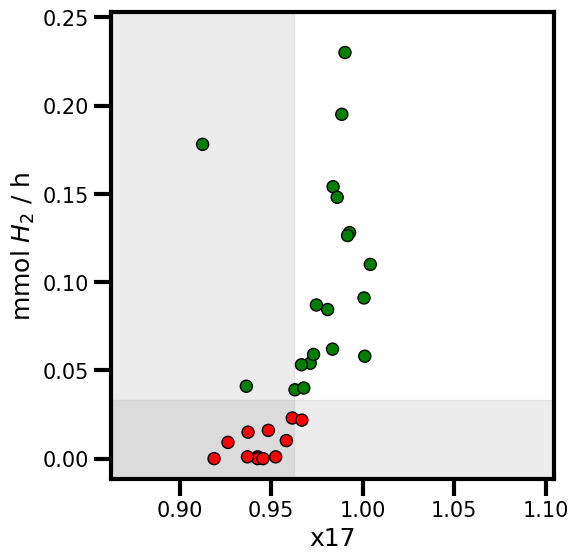

-------------------------------------------------------
N = 31
Feature: x32
Decision threshold = 246.87
Accuracy: 0.90
f1_score: 0.92
MCC: 0.80 
Recall: = 0.89
Classification Report: 
                 precision    recall  f1-score   support

0 ("negatives")       0.85      0.92      0.88        12
1 ("positives")       0.94      0.89      0.92        19

       accuracy                           0.90        31
      macro avg       0.90      0.91      0.90        31
   weighted avg       0.91      0.90      0.90        31



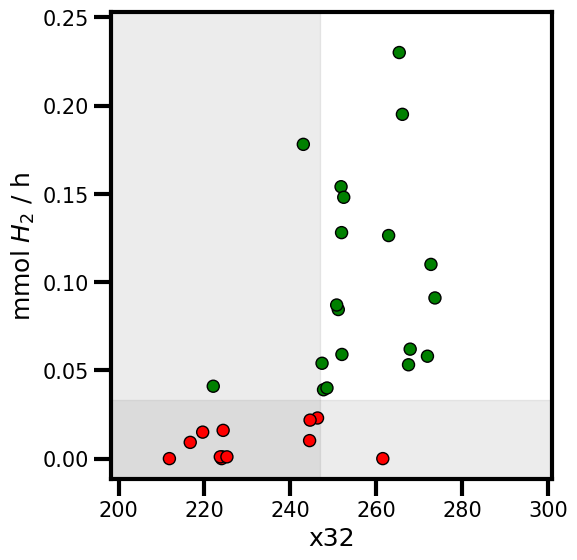

-------------------------------------------------------


In [7]:
#********************************************************************
#Single Node Decision Tree Analysis for all Features
#********************************************************************

#class_weight = {0:1,1:20}   # define class weights
class_weight = "balanced"
accuracy_cutoff = 0.9 #define accuracy cutoff to only get selected features

target_names = ['0 ("negatives")',  '1 ("positives")']

#set which parameters/features to iterate through
features = range(0,len(X_labels))

#threshold analysis for selected features
for f_ind in features:
    feature = X_labels[f_ind] 
    
    dt = DecisionTreeClassifier(max_depth=1,class_weight=class_weight).fit(X[:,f_ind].reshape(-1, 1), y_class)  
    if dt.score(X[:,f_ind].reshape(-1, 1), y_class) >= accuracy_cutoff:
        print("N = {}\nFeature: {}\nDecision threshold = {:.2f}\nAccuracy: {:.2f}\nf1_score: {:.2f}\nMCC: {:.2f} \nRecall: = {:.2f}\nClassification Report: \n{}".format(len(y),feature,
        dt.tree_.threshold[0],
        dt.score(X[:,f_ind].reshape(-1, 1), y_class),
        metrics.f1_score(y_class,dt.predict(X[:,f_ind].reshape(-1, 1))),
        metrics.matthews_corrcoef(y_class,dt.predict(X[:,f_ind].reshape(-1, 1))),
        metrics.recall_score(y_class, dt.predict(X[:,f_ind].reshape(-1, 1)), pos_label=1, average='binary'),
        metrics.classification_report(y_class, dt.predict(X[:,f_ind].reshape(-1, 1)), target_names=target_names),              
        ))
    
        # begin plot
        dt_plt = DecisionTreeClassifier(max_depth=1,class_weight=class_weight).fit(X[:,f_ind].reshape(-1, 1), y_class)
        n_classes = 2
        plot_step = 0.02
    
        # define plot axes limits here as appropriate 
        x_min, x_max = X[:,f_ind].min(), X[:,f_ind].max()
        y_min, y_max = y.min(), y.max()
    
        # set plot colors
        cMap_background = ListedColormap(['white', '#ccebc5',]) # color for the backgrounds: light green and red
        cMap_points = ListedColormap(["r","g"]) # the color for each class of the actual data points (i.e. inactive/active)). "rg" is red,green
    
        # plot code
        fig = plt.figure(figsize=(6, 6)) 
        ax = fig.add_subplot()
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(3)
        ax.tick_params(length=12,width=3)
        ax.set_ylim([y_min-0.05*y_max,y_max*1.1])
        ax.set_xlim([x_min-0.05*x_max,x_max*1.1])

        plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=3.5)
        plt.xlabel(feature,fontsize=18)
        plt.ylabel(r"mmol $H_{2}$ / h",fontsize=18)
        plt.xticks(fontsize=15)
        plt.yticks(fontsize=15)

        ax.axhspan(ymin=y_min-0.05*y_max,ymax=y_cut,color='grey',alpha=0.15)
        ax.axvspan(xmin=x_min-0.05*x_max,xmax=dt.tree_.threshold[0],color="grey",alpha=0.15)
    
        plt.scatter(X[:,f_ind],y,c=y_class,cmap=cMap_points,edgecolor="black",s=75)
    
        # Print plot
        plt.show()
    
        print('-------------------------------------------------------')

# G. Logistic Regression

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split,RepeatedKFold,cross_val_score,cross_validate
from logreg_stats import calc_mcfad, calc_mcfadden_R2, precision_recall_f1_score, test_accuracy_score, kfold_logreg 
import multiprocessing
nproc = max([1,multiprocessing.cpu_count()-2])
import warnings
warnings.filterwarnings("ignore")
randomstate = 42
import Logistic_Regression as fsc

## Define Plotting Functions
### Define plotting function for one-parameter logistic regression

- No user input required

In [9]:
def plot_fit_1D(feat, df_combined, save_fig=False):  
    X_train = np.array(df_combined.loc[:, [feat]])
    y_train = np.array(df_combined.iloc[:, -1])
    lr = LogisticRegression().fit(X_train,y_train)
    m, b = lr.coef_[0][0], lr.intercept_[0]
    feat_name = X_labelname_dict[feat]

    x_min, x_max = min(X_train), max(X_train)
    x_range = x_max - x_min
    plot_min, plot_max = float(x_min-0.05*x_range), float(x_max+0.05*x_range)

    fig= plt.figure(figsize=(6,6))
    ax = fig.add_subplot()
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(3)
    ax.tick_params(length=12,width=3)

    ax.tick_params(which='minor', length=6, width=3)

    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=3.5)

    plt.xticks(fontsize=15) 
    plt.yticks(fontsize=15)
    plt.xlabel(feat_name,fontsize=18)
    plt.ylabel('Probability',fontsize=18)
    #plt.locator_params(axis='y', nbins=4)
    #plt.locator_params(axis='x', nbins=5)
    plt.axvline(x=(-b/m),alpha=1,c='black')
    plt.axvline(x=((np.log(3)-b)/m),alpha=1,c='black', linestyle = '--')
    plt.axvline(x=((np.log(1/3)-b)/m),alpha=1,c='black', linestyle = '--')
    plt.scatter(X_train, y_train, label="training", alpha=1,marker='o', c ='Blue', s=150  ,edgecolor='black')
    plt.xlim(plot_min, plot_max)
    plt.ylim(-.05, 1.05)

    x = np.linspace(x_min-0.4*x_range, x_max+0.4*x_range)
    f_x = np.exp(b + m*x)
    y_sigmoid = f_x/(f_x + 1)
    plt.plot(x, y_sigmoid, color = 'black')
    if save_fig:
        fig.savefig(feat + '.tif', dpi=600)
    plt.show()

### Define plotting function for 2D logistic regression

- No user input required
- colormap_scheme, test_points, train_points, point_color, and point_size can be changed to adjust the appearance of the plot

In [10]:
colormap_scheme = 'RdBu'
test_points, train_points = 'X', 'o' # marker shape of test set ('*', <, >, x, X, o, O, b, d,. )
point_color = 'Greys'# 'Greens', 'Oranges', 'Reds','YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu', 'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn'
point_size = 100

def heatmap_logreg(feat1, feat2, df_train, df_test, model, annotate_test = False, annotate_train = False):  
    #Train model on features
    p1_vals = df_train.iloc[:, feat1]
    p2_vals = df_train.iloc[:, feat2]
    p1_vals_test = df_test.iloc[:, feat1]
    p2_vals_test = df_test.iloc[:, feat2]
    lr = LogisticRegression().fit(df_train.iloc[:,[feat1, feat2]],y_train)
    intercept = lr.intercept_[0]
    c1, c2 = lr.coef_[0][0], lr.coef_[0][1]
    p1, p2 = X_names[feat1], X_names[feat2]
    
    if p1=="δ_Cavg":
        p1= r"$\delta_{\mathregular{C}}^{\mathregular{{avg}}}$"
    if p2=="δ_Cavg":
        p2= r"$\delta_{\mathregular{C}}^{\mathregular{{avg}}}$"
        
    #Get max/min values for X and Y axes
    max_x, min_x = max(list(p1_vals) + list(p1_vals_test)), min(list(p1_vals) + list(p1_vals_test))
    max_y, min_y = max(list(p2_vals) + list(p2_vals_test)), min(list(p2_vals) + list(p2_vals_test))
    range_x, range_y = abs(max_x - min_x), abs(max_y - min_y)
    max_x_plt, min_x_plt = max_x + 0.1*range_x, min_x - 0.1*range_x
    max_y_plt, min_y_plt = max_y + 0.1*range_y, min_y - 0.1*range_y
    
    #heatmap code
    xx = np.linspace(min_x_plt, max_x_plt, 500)
    yy = np.linspace(min_y_plt, max_y_plt, 500)
    xx,yy = np.meshgrid(xx, yy)
    Xfull = np.c_[xx.ravel(), yy.ravel()]
   
    # Predict probabilities of full grid
    probas = lr.predict_proba(Xfull)
    

    fig= plt.figure(figsize=(7.25,6))
    ax = fig.add_subplot()
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(3)
    ax.tick_params(length=12,width=3)

    ax.tick_params(which='minor', length=6, width=3)

    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=3.5)
    plt.xticks(fontsize=15) 
    plt.yticks(fontsize=15)
    ax.xaxis.set_major_locator(plt.MaxNLocator(5))
    ax.yaxis.set_major_locator(plt.MaxNLocator(4))
    plt.xlabel(p1,fontsize=18)
    plt.ylabel(p2,fontsize=18)

    
    x = np.linspace(min_x - 0.1*range_x, max_x + 0.1*range_x)
    y = -(intercept/c2) - (c1/c2)*x
    y_75 = ((np.log(3)-intercept)/c2) - (c1/c2)*x    #
    y_25 = ((np.log(1/3)-intercept)/c2) - (c1/c2)*x
    plt.xlim([min_x - 0.1*range_x, max_x + 0.1*range_x])
    plt.ylim([min_y - 0.1*range_y, max_y + 0.1*range_y])

    plt.plot(x, y, color = 'black')
    plt.plot(x,y_75, color = 'black', linestyle = '--')
    plt.plot(x,y_25, color = 'black', linestyle = '--')
    
    heatmap = plt.imshow(
            probas[:,1].reshape((500, 500)), cmap=colormap_scheme, alpha = 0.5, extent=[min_x_plt, max_x_plt, min_y_plt, max_y_plt],interpolation='nearest', origin="lower"
        ,aspect='auto')
    cbar = plt.colorbar(heatmap)
    cbar.ax.tick_params(labelsize=15)
    cbar.set_label('Probability', size=18)
    plt.clim(0,1)
    plt.locator_params(axis='y', nbins=5)
    plt.locator_params(axis='x', nbins=5)
    plt.scatter(p1_vals, p2_vals, label="training", alpha=1,marker='o', c = df_train.iloc[:, -1], cmap=point_color + '_r', s=200  ,edgecolor='black')
    plt.scatter(p1_vals_test, p2_vals_test, label="test", alpha=1,marker='X' , c = df_test.iloc[:, -1], cmap=point_color + '_r', s=200  ,edgecolor='black')
    #plt.colorbar()
    #cbar.set_label('yield %',rotation=90,size=22,labelpad=20)

    
    if annotate_test == True:
        for i, txt in enumerate(VS):
            label_i = y_labels[txt]
            plt.annotate(label_i, (p1_vals_test[i], p2_vals_test[i]), fontsize='14', c = 'white')
    if annotate_train == True:
        for i, txt in enumerate(TS):
            label_i = y_labels[txt]
            plt.annotate(label_i, (p1_vals[i], p2_vals[i]), fontsize='14', c = 'white')
    plt.tight_layout()
    fig.savefig('Logistic_Regression.tif', dpi=600)
    plt.show()

## Univariate correlations and feature/feature plotting

### Univariate Logistic Regression

- Runs univariate logistic regression for all parameters and creates a dataframe of models in decending order of McFadden R2
- No user input required

In [11]:
from logreg_stats import calc_mcfad

results_1_param = pd.DataFrame(columns=['Model', 'Accuracy', 'McFadden_R2', 'Param_name', 'Threshold_Value'])

count = 0
for i in range(len(X_labels)):
    term = X_labels[i]
    X_sel = X[:, i].reshape(-1,1)
    lr = LogisticRegression().fit(X_sel,y_class)
    acc = round(lr.score(X_sel,y_class), 2)
    mcfad_r2 = round(calc_mcfad(X_sel, y_class), 2)
    m, b = lr.coef_[0][0], lr.intercept_[0]
    row_i = {'Model': term, 'Accuracy': acc, 'McFadden_R2': mcfad_r2, 'Param_name': X_labelname_dict[term], 'Threshold_Value': -b/m}
    results_1_param = results_1_param.append(row_i, ignore_index=True)

results_1_param = results_1_param.sort_values('McFadden_R2', ascending=False)
results_1_param.head(10)

,Model,Accuracy,McFadden_R2,Param_name,Threshold_Value
27,x28,0.84,0.43,σ_Cavg,92.857723
31,x32,0.84,0.42,σzz_Cavg,240.109740
35,x36,0.81,0.29,L_Cavg,6.322638
0,x1,0.77,0.26,MW,179.488839
40,x41,0.77,0.25,ΔB5_C,1.074626
29,x30,0.77,0.22,σxx_Cavg,11.077475
33,x34,0.71,0.19,Δσyy_C,17.946054
43,x44,0.81,0.19,Vtot,216.313753
32,x33,0.71,0.18,Δσxx_C,18.405816
41,x42,0.77,0.17,Vbur,88.060937


### Plot top univariates

- prints top n models (n = num_plots)
- populate num_plots and skipfeatures

x28 σ_Cavg. Threshold value 92.86
Accuracy: 84%
McFadden R2: 0.43


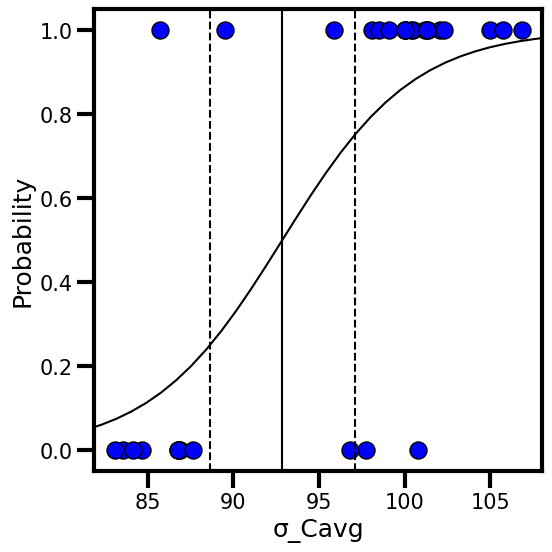




x32 σzz_Cavg. Threshold value 240.11
Accuracy: 84%
McFadden R2: 0.42


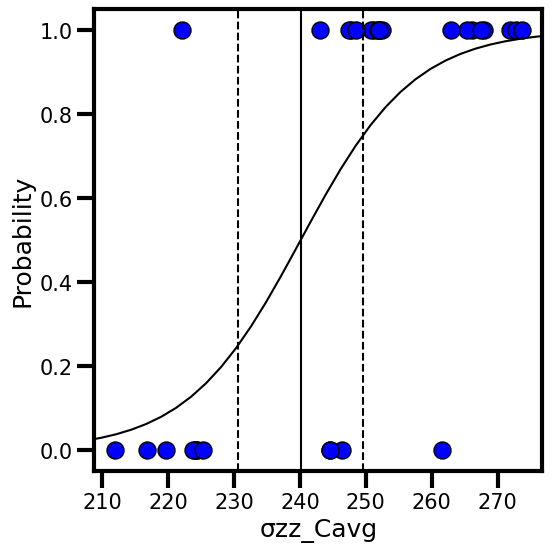




x36 L_Cavg. Threshold value 6.32
Accuracy: 81%
McFadden R2: 0.29


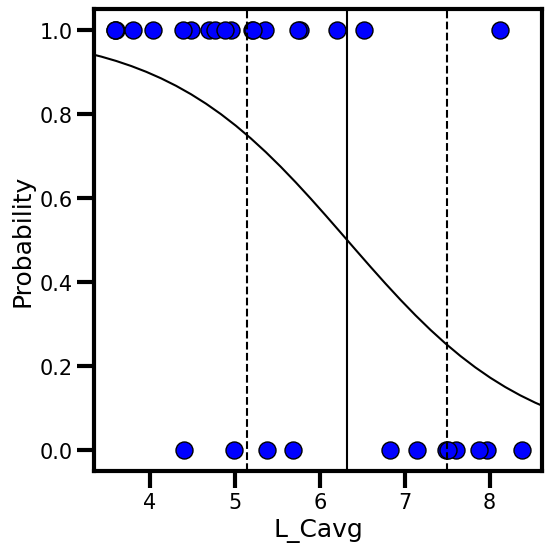

In [12]:
num_plots = 3  #Specify how many univariates to plot
skipfeatures = []  # add any features that you don't want to plot, e.g. ['x1', 'x28']


df_combined = pd.DataFrame(np.hstack((X,y_class[:,None]))) 
newcols = ["x"+str(i+1) for i in df_combined.columns.values]
df_combined.columns = newcols
response = newcols[-1]
df_combined.rename(columns={response:"y"},inplace=True)
df_combined.drop(skipfeatures,axis=1,inplace=True)

for i in range(num_plots):
    param_i = results_1_param.iloc[i].Model
    param_name = X_labelname_dict[param_i]
    threshold = results_1_param.iloc[i].Threshold_Value
    print("{} {}. Threshold value {:.2f}".format(param_i, param_name, threshold))
    print("Accuracy: {:.0f}%".format(100*results_1_param.iloc[i].Accuracy))
    print("McFadden R2: {}".format(results_1_param.iloc[i].McFadden_R2))
    plot_fit_1D(param_i, df_combined, save_fig=False)
    print("\n\n")

### Plot a univariate logistic regression with a user-defined parameter 

- Runs univariate logistic regression for user-defined parameter list
- Populate plot_params

x28 σ_Cavg. Threshold value 92.86
Accuracy: 84%
McFadden R2: 0.43


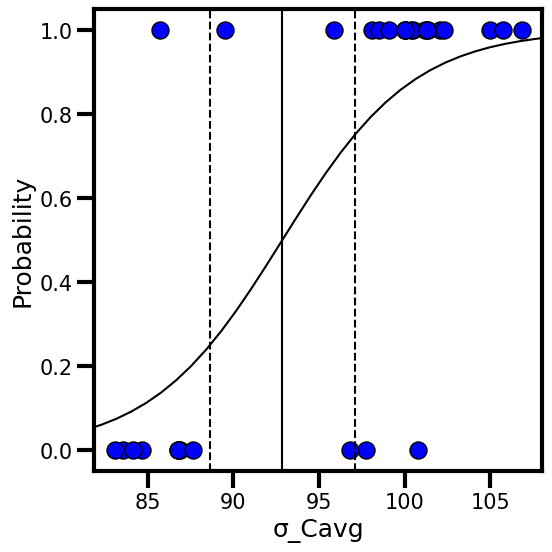




x41 ΔB5_C. Threshold value 1.07
Accuracy: 77%
McFadden R2: 0.25


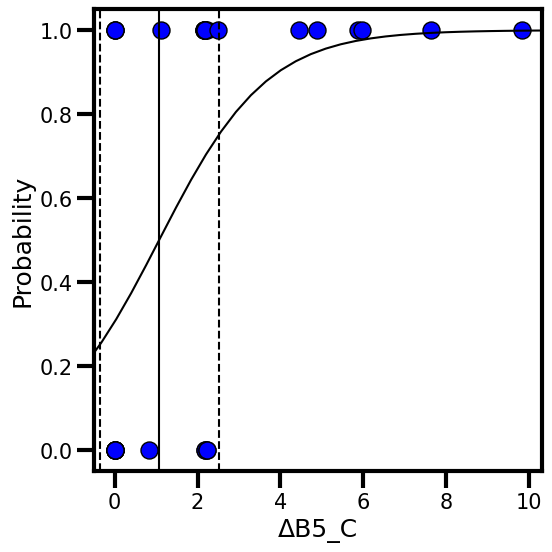

In [13]:
plot_params = ['x28','x41'] #populate with a list of parameters (e.g. plot_params = ['x1', 'x20', 'x21'])

for param_i in plot_params:
    row = results_1_param[results_1_param.Model == param_i]
    param_name = X_labelname_dict[param_i]
    threshold = float(row.Threshold_Value)
    acc = float(row.Accuracy)
    mcfad_r2 = float(row.McFadden_R2)
    print("{} {}. Threshold value {:.2f}".format(param_i, param_name, threshold))
    print("Accuracy: {:.0f}%".format(100*acc))
    print("McFadden R2: {}".format(mcfad_r2))
    plot_fit_1D(param_i,df_combined)
    print("\n\n")

### plot a feature vs. another feature

- plots one feature vs another to determine possible correlations
- Select two features to visualize (f_ind_1, f_ind_2)

x28 σ_Cavg
x9 Total Dipole

31 samples
R^2 = 0.10; p-value = 8.94E-02


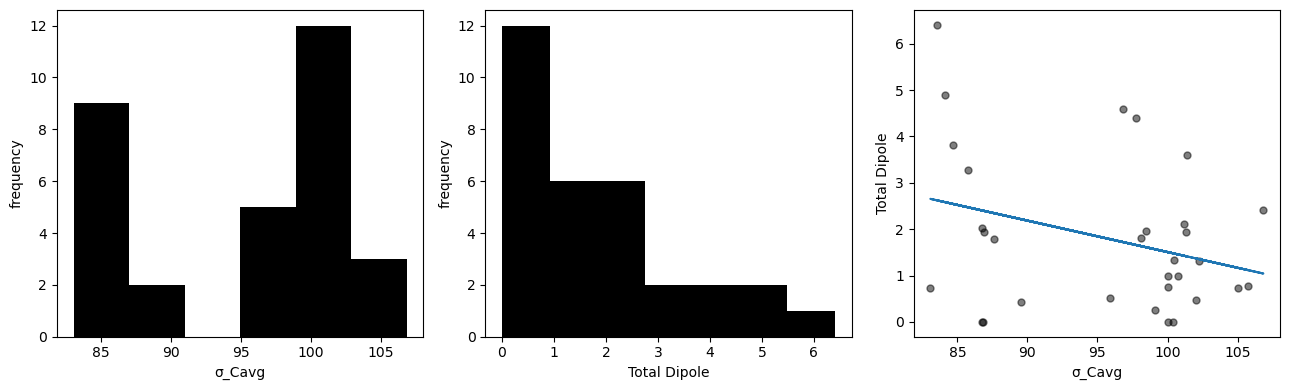

In [14]:
f_ind_1 = "x28" # feature of interest 1 (e.g. 'x1')
f_ind_2 = "x9" # feature of interest 2 (e.g. 'x20')

if type(f_ind_1) == str:
    [f_ind_1,f_ind_2] = [X_labels.index(i) for i in [f_ind_1,f_ind_2]]

print(X_labels[f_ind_1], X_names[f_ind_1])
print(X_labels[f_ind_2], X_names[f_ind_2])
print("\n{} samples".format(np.shape(X[:,f_ind_1])[0]))
slope, intercept, r_value, p_value, std_err = stats.linregress(X[:,f_ind_1],X[:,f_ind_2])
fit_line = intercept+slope*X[:,f_ind_1]
print("R^2 = {:.2f}; p-value = {:.2E}".format(r_value**2,p_value))

plt.figure(figsize=(13, 4))

plt.subplot(1,3,1)
plt.hist(X[:,f_ind_1], bins="auto",color="black")
plt.ylabel("frequency")
plt.xlabel(X_names[f_ind_1])
plt.subplot(1,3,2)
plt.hist(X[:,f_ind_2], bins="auto",color="black")
plt.ylabel("frequency")
plt.xlabel(X_names[f_ind_2])

plt.subplot(1,3,3)
plt.scatter(X[:,f_ind_1], X[:,f_ind_2],color="black",marker=".",alpha=0.5,s=100)    
plt.plot(X[:,f_ind_1],fit_line)
plt.xlabel(X_names[f_ind_1])
plt.ylabel(X_names[f_ind_2])
plt.tight_layout()
plt.show()  


## Data preparation

 - populate split and test_ratio

TS: [24, 6, 22, 23, 18, 17, 2, 12, 20, 26, 8, 14, 1, 15, 4, 29, 21, 0, 28, 3, 11]
VS: [16, 27, 25, 5, 13, 9, 30, 7, 10, 19]
y_mean TS: 0.571
y_mean VS: 0.700
Shape X_train: (21, 44)
Shape X_test:  (10, 44)


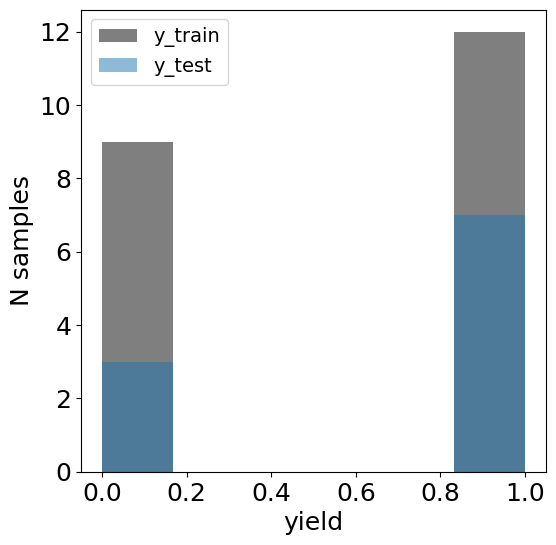

In [15]:
# Methods to split the data:
# 'random': randomly assigns train/test split
# 'define': give a list of ligand IDs for the training set (TS) and validation set (VS) in the corresponding code section.
# 'none': all samples in TS.

split = "random"  # use one of the methods outlined above
test_ratio = 0.3 # float from 0.0 to 1.0. Only relevant when split = 'random'

X_sel,y_sel,labels_sel,exclude = X,y_class,y_labels,[]

if split == "random":
    X_train, X_test, y_train, y_test = train_test_split(
        X_sel, y_sel, random_state=randomstate+3, test_size=test_ratio)    
    TS = [np.argwhere(np.all(X==i,axis=1))[0,0] for i in X_train]
    VS = [np.argwhere(np.all(X==i,axis=1))[0,0] for i in X_test]
    
elif split == "define":
    VS_IDS = ["16", "27", "25", "5", "13", "9", "30", "7", "10", "19"]
    TS_IDS = ["24", "6" "22", "23", "18", "17", "2", "12", "20", "26", "8", "14", "1", "15",
              "4", "29", "21", "0", "28", "3", "11"]
    VS = []
    TS = []
    for i in VS_IDS:
        try:
            num_i = expinp.index.get_loc(str(i))
        except:
            num_i = expinp.index.get_loc(int(i))
        VS.append(num_i)
    for i in TS_IDS:
        try:
            num_i = expinp.index.get_loc(str(i))
        except:
            num_i = expinp.index.get_loc(int(i))
        TS.append(num_i)
    print(VS, TS)
    X_train, y_train,X_test, y_test = X[TS],y[TS],X[VS],y[VS]

elif split == "none":
    TS, VS = [i for i in range(X.shape[0]) if i not in exclude],[]
    X_train, y_train,X_test, y_test = X[TS],y[TS],X[VS],y[VS]
else: 
    raise ValueError("split option not recognized")
     
print("TS: {}".format(TS))
print("VS: {}".format(VS))
print("y_mean TS: {:.3f}".format(np.mean(y_train)))
print("y_mean VS: {:.3f}".format(np.mean(y_test)))
print("Shape X_train: {}".format(X_train.shape))
print("Shape X_test:  {}".format(X_test.shape))   
plt.figure(figsize=(6, 6))
hist,bins = np.histogram(y_sel,bins="auto")#"auto"
plt.hist(y_train, bins, alpha=0.5, label='y_train',color="black")
plt.hist(y_test, bins, alpha=0.5, label='y_test')
plt.legend(loc='best',fontsize=14)
plt.xlabel("yield",fontsize=18)
plt.ylabel("N samples",fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

## Run Logistic Regression
### Prep data

- Prepares data for modelling (descriptors and results)
- populate skipfeatures with parameters that you don't want the model to evaluate

In [16]:
skipfeatures = []       
df_train = pd.DataFrame(np.hstack((X_train,y_train[:,None])))     
newcols = ["x"+str(i+1) for i in df_train.columns.values]
df_train.columns = newcols
response = newcols[-1]
df_train.rename(columns={response:"y"},inplace=True)
df_train.drop(skipfeatures,axis=1,inplace=True)


df_test = pd.DataFrame(np.hstack((X_test,y_test[:,None])))
newcols = ["x"+str(i+1) for i in df_test.columns.values]
df_test.columns = newcols
response = newcols[-1]
df_test.rename(columns={response:"y"},inplace=True)
df_test.drop(skipfeatures,axis=1,inplace=True)

### Manual selection of features

- Runs 2D logistic regression with user-defined parameters
- populate features_x, annotate_test_set, annotate_training_set

Parameters and coefficients:
  -19.7773 + 
   -0.4665 * x9 Total Dipole
    0.2198 * x28 σ_Cavg

McFadden Training R2  = 0.42
McFadden Test R2  = 0.57

Accuracy  = 90.5 %
Test Accuracy  = 90.0%

Training K-fold Accuracy = 81.00 (+/- 2.31) %
f1 Score  = 0.903
Precision Score  = 0.903
Recall Score  = 0.903

Note: 
(1) Black and white points denote active and inactive ligands respectively.
(2) Red and blue denote active and inactive chemical space respectively.
(3) Dashed lines denote 25% and 75% probability that a ligand will be active.
(4) Solid black line denotes 50% probability that a ligand will be active.


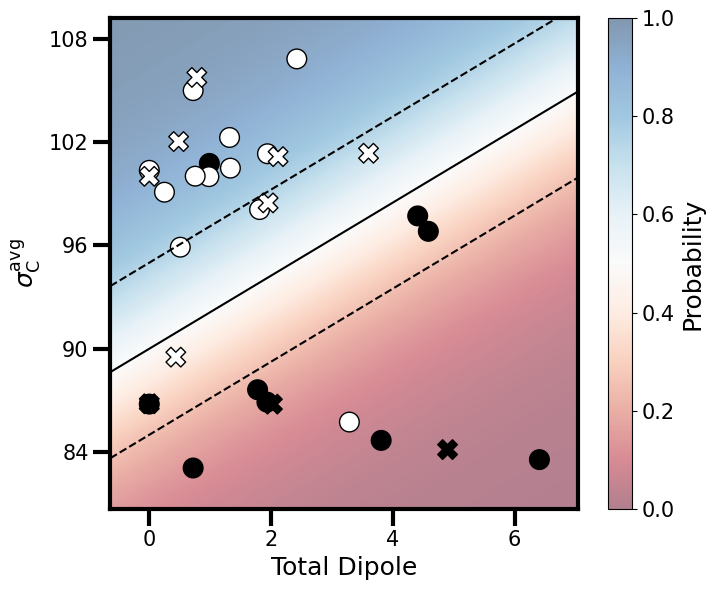

In [17]:
features_x = ('x9', 'x28') # tuple of features. eg ('x1', 'x10')
annotate_test_set = False    # set to True if you want to test set points labeled with ligand id 
annotate_training_set = False    # set to True if you want to training set points labeled with ligand id 


selected_feats = sorted([X_labels.index(i.strip()) for i in features_x])
X_train_sel = X_train[:,selected_feats]
X_test_sel = X_test[:,selected_feats]
lr = LogisticRegression().fit(X_train_sel,y_train)
y_pred_train = lr.predict(X_train_sel)
if len(VS) > 0:  
    test_accuracy = test_accuracy_score(X_test_sel, y_test, X_train_sel, y_train)  
kfold_score, kfold_stdev = kfold_logreg(X_train_sel, y_train)
precision, recall, f1 = precision_recall_f1_score(X_train_sel, y_train)
train_R2, test_R2 = calc_mcfadden_R2(X_train_sel, y_train, X_test_sel, y_test)

print("Parameters and coefficients:\n{:10.4f} + \n".format(lr.intercept_[0]) + "\n".join(["{:10.4f} * {}".format(lr.coef_[0][i],X_labelname[selected_feats[i]]) for i in range(len(selected_feats))]))
print(f"\nMcFadden Training R2  = {train_R2 :.2f}")
if len(VS) > 0:
    print(f"McFadden Test R2  = {test_R2 :.2f}")
print(f"\nAccuracy  = {100 * lr.score(X_train_sel, y_train):.1f} %")
if len(VS) > 0:
    print(f"Test Accuracy  = {100 * lr.score(X_test_sel, y_test):.1f}%")
print("\nTraining K-fold Accuracy = {:.2f} (+/- {:.2f}) %".format(100* kfold_score, 100* kfold_stdev ** 2))
print(f"f1 Score  = {f1:.3f}")
print(f"Precision Score  = {precision :.3f}")
print(f"Recall Score  = {recall:.3f}")
print('\nNote: \n(1) Black and white points denote active and inactive ligands respectively.')
print('(2) Red and blue denote active and inactive chemical space respectively.')
print('(3) Dashed lines denote 25% and 75% probability that a ligand will be active.')
print('(4) Solid black line denotes 50% probability that a ligand will be active.')


heatmap_logreg(selected_feats[0],selected_feats[1],df_train,df_test,features_x, annotate_test=annotate_test_set, annotate_train=annotate_training_set)


###  Forward Stepwise Logistic Regression

- Runs logistic regression using all 2-parameter combinations (within collin_criteria)
- Populate collin_criteria

In [ ]:
collin_criteria = 0.7   # the maximum allowed R2 between terms in a given model

# Runs forward stepwise model search
results,models,scores,sortedmodels,candidates = fsc.ForwardStep_py(df_train,'y',
                    collin_criteria=collin_criteria)

# Identifies model with highest Accuracy
model_sel = results.loc[0,"Model"]
selected_feats = [X_labels.index(i) for i in models[model_sel].terms]
print("\n\nModel with the highest Accuracy:")
print(models[model_sel].formula)
print("1 + "+" + ".join([X_names[X_labels.index(i)] for i in models[candidates[0]].terms])+"\n")

# Finds features used in best model for the training/test data, reruns lr, get statistics
X_train_sel = X_train[:,selected_feats]
X_test_sel = X_test[:,selected_feats]
lr = LogisticRegression()
lr.fit(X_train_sel,y_train)
kfold_score, kfold_stdev = kfold_logreg(X_train_sel, y_train)
precision, recall, f1 = precision_recall_f1_score(X_train_sel, y_train)
train_R2, test_R2 = calc_mcfadden_R2(X_train_sel, y_train, X_test_sel, y_test)

# Plots model and prints stats
print("Parameters and coefficients:\n{:10.4f} + \n".format(lr.intercept_[0]) + "\n".join(["{:10.4f} * {}".format(lr.coef_[0][i],X_labelname[selected_feats[i]]) for i in range(len(selected_feats))]))
print(f"\nMcFadden Training R2  = {train_R2 :.2f}")
if len(VS) > 0:
    print(f"McFadden Test R2  = {test_R2 :.2f}")
print(f"\nTraining Accuracy   = {100 * lr.score(X_train_sel, y_train):.3f} %")
if len(VS) > 0:  # This is False if no data was left out as a test set. 
    print(f"Test Accuracy  = {100 * lr.score(X_test_sel, y_test):.1f}%")
print("\nTraining K-fold Accuracy = {:.2f} (+/- {:.2f}) %".format(100* kfold_score, 100* kfold_stdev ** 2))
print(f"f1 Score  = {f1:.3f}")
print(f"Precision Score  = {precision :.3f}")
print(f"Recall Score  = {recall:.3f}")

if len(model_sel) > 1:
    heatmap_logreg(selected_feats[0],selected_feats[1],df_train,df_test,results.iloc[0][0])
else:
    print("The model with the highest accuracy is a 1-parameter model!")

### Display multiple models

- prints out the top n models in a dataframe
- populate within the results1.head() parenthesis

In [ ]:
results['Param_1'] = results.Model.apply(lambda x: X_labelname_dict[x[0]])
results['Param_2'] = results.Model.apply(lambda x: X_labelname_dict[x[1]] if len(x) == 2 else "1-term")
results1 = results.sort_values('McFadden_R2', ascending=False)
results1 = results1.round(2)
results1 = results1[['Model', 'Accuracy', 'McFadden_R2', 'Param_1', 'Param_2', 'n_terms']]

results1.head(10) # put the number of models you want displayed in the parenthesis


In [ ]:
# This cell will print all models with a given parameter

interest_param = 'δzz_Cavg'
results2 = results1[(results1.Param_1 == interest_param)| (results1.Param_2 == interest_param)]
results2.head(20)

### Visualize a specific model

- Prints plot and statistics for a model of interest
- populate model number with the index of the model that you want to plot
- populate annotate_train and annotate test

(note that this only plots models that are within the results1 dataframe)

In [ ]:
model_number = 7
annotate_test_set = True    # set to True if you want test set points labeled with ligand ID
annotate_training_set = True    # set to True if you want training set points labeled with ligand ID

model_sel = results.loc[model_number,"Model"]

selected_feats = [X_labels.index(i) for i in models[model_sel].terms]
X_train_sel = X_train[:,selected_feats]
X_test_sel = X_test[:,selected_feats]
lr = LogisticRegression().fit(X_train_sel,y_train)
y_pred_train = lr.predict(X_train_sel)
if len(VS) > 0:  
    test_accuracy = test_accuracy_score(X_test_sel, y_test, X_train_sel, y_train)  
kfold_score, kfold_stdev = kfold_logreg(X_train_sel, y_train)
precision, recall, f1 = precision_recall_f1_score(X_train_sel, y_train)
train_R2, test_R2 = calc_mcfadden_R2(X_train_sel, y_train, X_test_sel, y_test)

print("Parameters and coefficients:\n{:10.4f} + \n".format(lr.intercept_[0]) + "\n".join(["{:10.4f} * {}".format(lr.coef_[0][i],X_labelname[selected_feats[i]]) for i in range(len(selected_feats))]))
print(f"\nMcFadden Training R2  = {train_R2 :.2f}")
if len(VS) > 0:
    print(f"McFadden Test R2  = {test_R2 :.2f}")
print(f"\nAccuracy  = {100 * lr.score(X_train_sel, y_train):.1f} %")
if len(VS) > 0:
    print(f"Test Accuracy  = {100 * lr.score(X_test_sel, y_test):.1f}%")
print("\nTraining K-fold Accuracy = {:.2f} (+/- {:.2f}) %".format(100* kfold_score, 100* kfold_stdev ** 2))
print(f"f1 Score  = {f1:.3f}")
print(f"Precision Score  = {precision :.3f}")
print(f"Recall Score  = {recall:.3f}")
print('\nNote: \n(1) Black and white points denote active and inactive ligands respectively.')
print('(2) Red and blue denote active and inactive chemical space respectively.')
print('(3) Dashed lines denote 25% and 75% probability that a ligand will be active.')
print('(4) Solid black line denotes 50% probability that a ligand will be active.')


heatmap_logreg(selected_feats[0],selected_feats[1],df_train,df_test,results.iloc[model_number][0], 
               annotate_test=annotate_test_set, annotate_train=annotate_training_set)



# H. Virtual screening

### Setup

- Re-makes descriptors dataframe and combines training and test sets
- No user input required

In [ ]:
ci = pd.read_excel(comp_file+'.xlsx', comp_sheet,index_col=0,header=1,engine='openpyxl')
X_all_names = np.array(ci.SMILES)
compinp = ci[ci.columns[1:]].loc[ci.index[:]]
compinp.dropna(axis=0,inplace=True)
X_all = np.array(compinp)
X_all_ids = np.array(compinp.index)

# add all of the results to the training set
print('Number of samples in original training set = ',len(y_train))
y_train = np.concatenate((y_train,y_test), axis=0)
X_train = np.concatenate((X_train,X_test), axis=0)
print('Number of samples in updated training set = ',len(y_train))

X_screen = X_all
X_ids = X_all_ids.astype(str)
X_names = X_all_names

### Plot the virtual screening results with the visualized model

- plots a histogram of virtual screening probabilities
- populate savefig

In [ ]:
savefig = False # True if you want to save the virtual screen histogram as a png

X_combined = []
for i in range(0,len(X_ids)):
    j = str(X_names[i]) + " (ID " + X_ids[i] + ")"
    X_combined.append(j)
    
plt.figure(figsize=(8,5))
plt.xticks(fontsize=12.5) 
plt.yticks(fontsize=12.5)
plt.xlabel("Probability that Alkyne is Active",fontsize=15)
plt.hist(y_pred_screen, bins="auto")
plt.ylabel("Frequency",fontsize=18)

if savefig:
    plt.savefig("virtual_screen.png",dpi=200)

plt.show()


### Create table of virtual screening results with the visualized model

In [ ]:
df = pd.DataFrame(list(zip(X_combined, y_pred_screen)), columns = ['Alkyne','Predicted_probability']).sort_values('Predicted_probability', ascending=False)
df1 = df.style.set_table_styles([dict(selector='th', props=[('text-align', 'center')])])
df1.set_properties(**{'text-align': 'center'}).hide_index()
df.to_excel('Predictions.xlsx', index = True)
df.head(10)